# Consumer Data Analysis

This is a consumer level dataset (Micro-level). An example of an aggregate level dataset will be the ads-sales data.

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

In [3]:
consumer_data = pd.read_excel('./data/consumer_data_50blank.xls')
consumer_data.head()

,customer_id,age,zipcode,choice
0,98348,40,90706,NaN
1,84860,15,90660,NaN
2,89003,30,93536,NaN
3,58852,40,90044,NaN
4,78007,30,90037,NaN


In [4]:
consumer_data['choice'].value_counts()

0.0    2677
1.0    1394
Name: choice, dtype: int64

The first 50 customer's choices on whether they chose product A or B is ommitted because we'll be trying to predict what they're preferences are.

In [5]:
train, test = \
    consumer_data[~consumer_data['choice'].isna()], consumer_data[consumer_data['choice'].isna()]

In [6]:
len(train)

4071

In [7]:
len(test)

50

If you can predict what they're going to buy, then we can recommend those items

---
## EDA

In [74]:
age_pdt_0, count_pdt_0 = list(zip(*list(train['age'][train['choice'] == 0].value_counts().items())))
age_pdt_1, count_pdt_1 = list(zip(*list(train['age'][train['choice'] == 1].value_counts().items())))

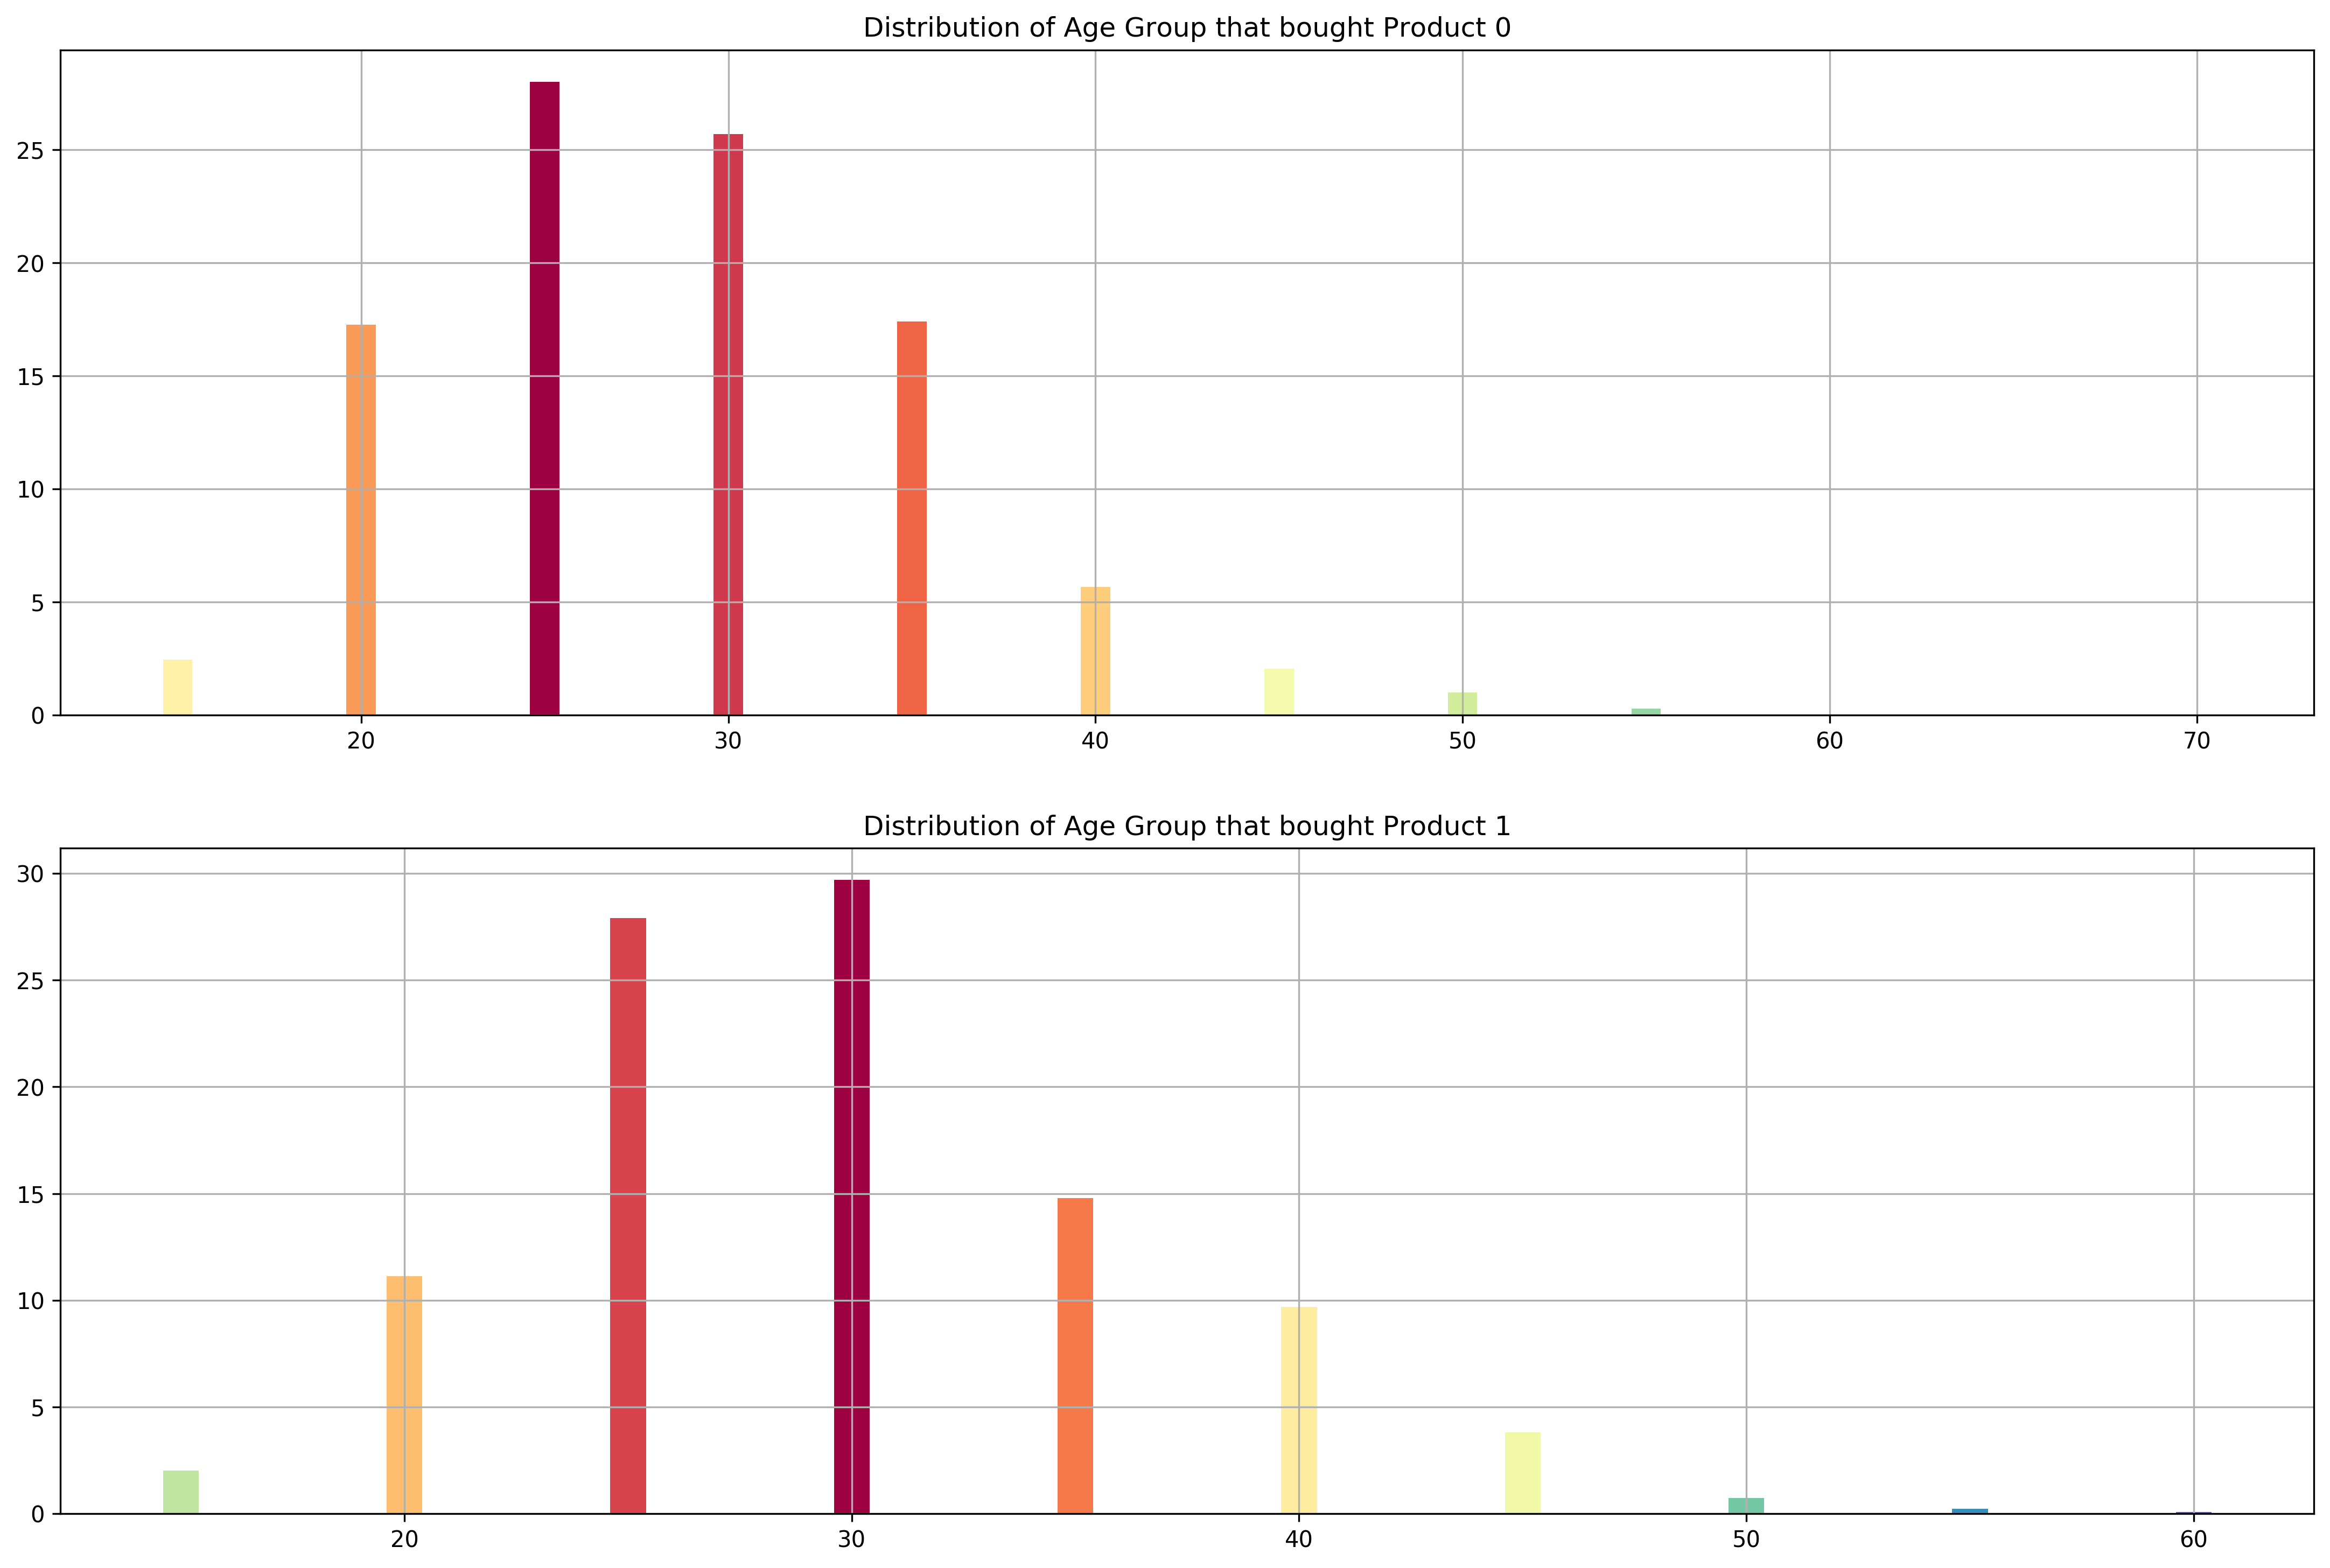

In [80]:
fig, ax = plt.subplots(2, 1)

ax[0].bar(age_pdt_0, np.multiply(count_pdt_0, 100) / np.sum(count_pdt_0), color=get_colors(len(count_pdt_0)))
ax[0].grid()
ax[0].set_title('Distribution of Age Group that bought Product 0');

ax[1].bar(age_pdt_1, np.multiply(count_pdt_1, 100) / np.sum(count_pdt_1), color=get_colors(len(count_pdt_1)))
ax[1].grid()
ax[1].set_title('Distribution of Age Group that bought Product 1');

plt.show();

In [81]:
zipcode_pdt_0, count_pdt_0 = list(zip(*list(train['zipcode'][train['choice'] == 0].value_counts().items())))
zipcode_pdt_1, count_pdt_1 = list(zip(*list(train['zipcode'][train['choice'] == 1].value_counts().items())))

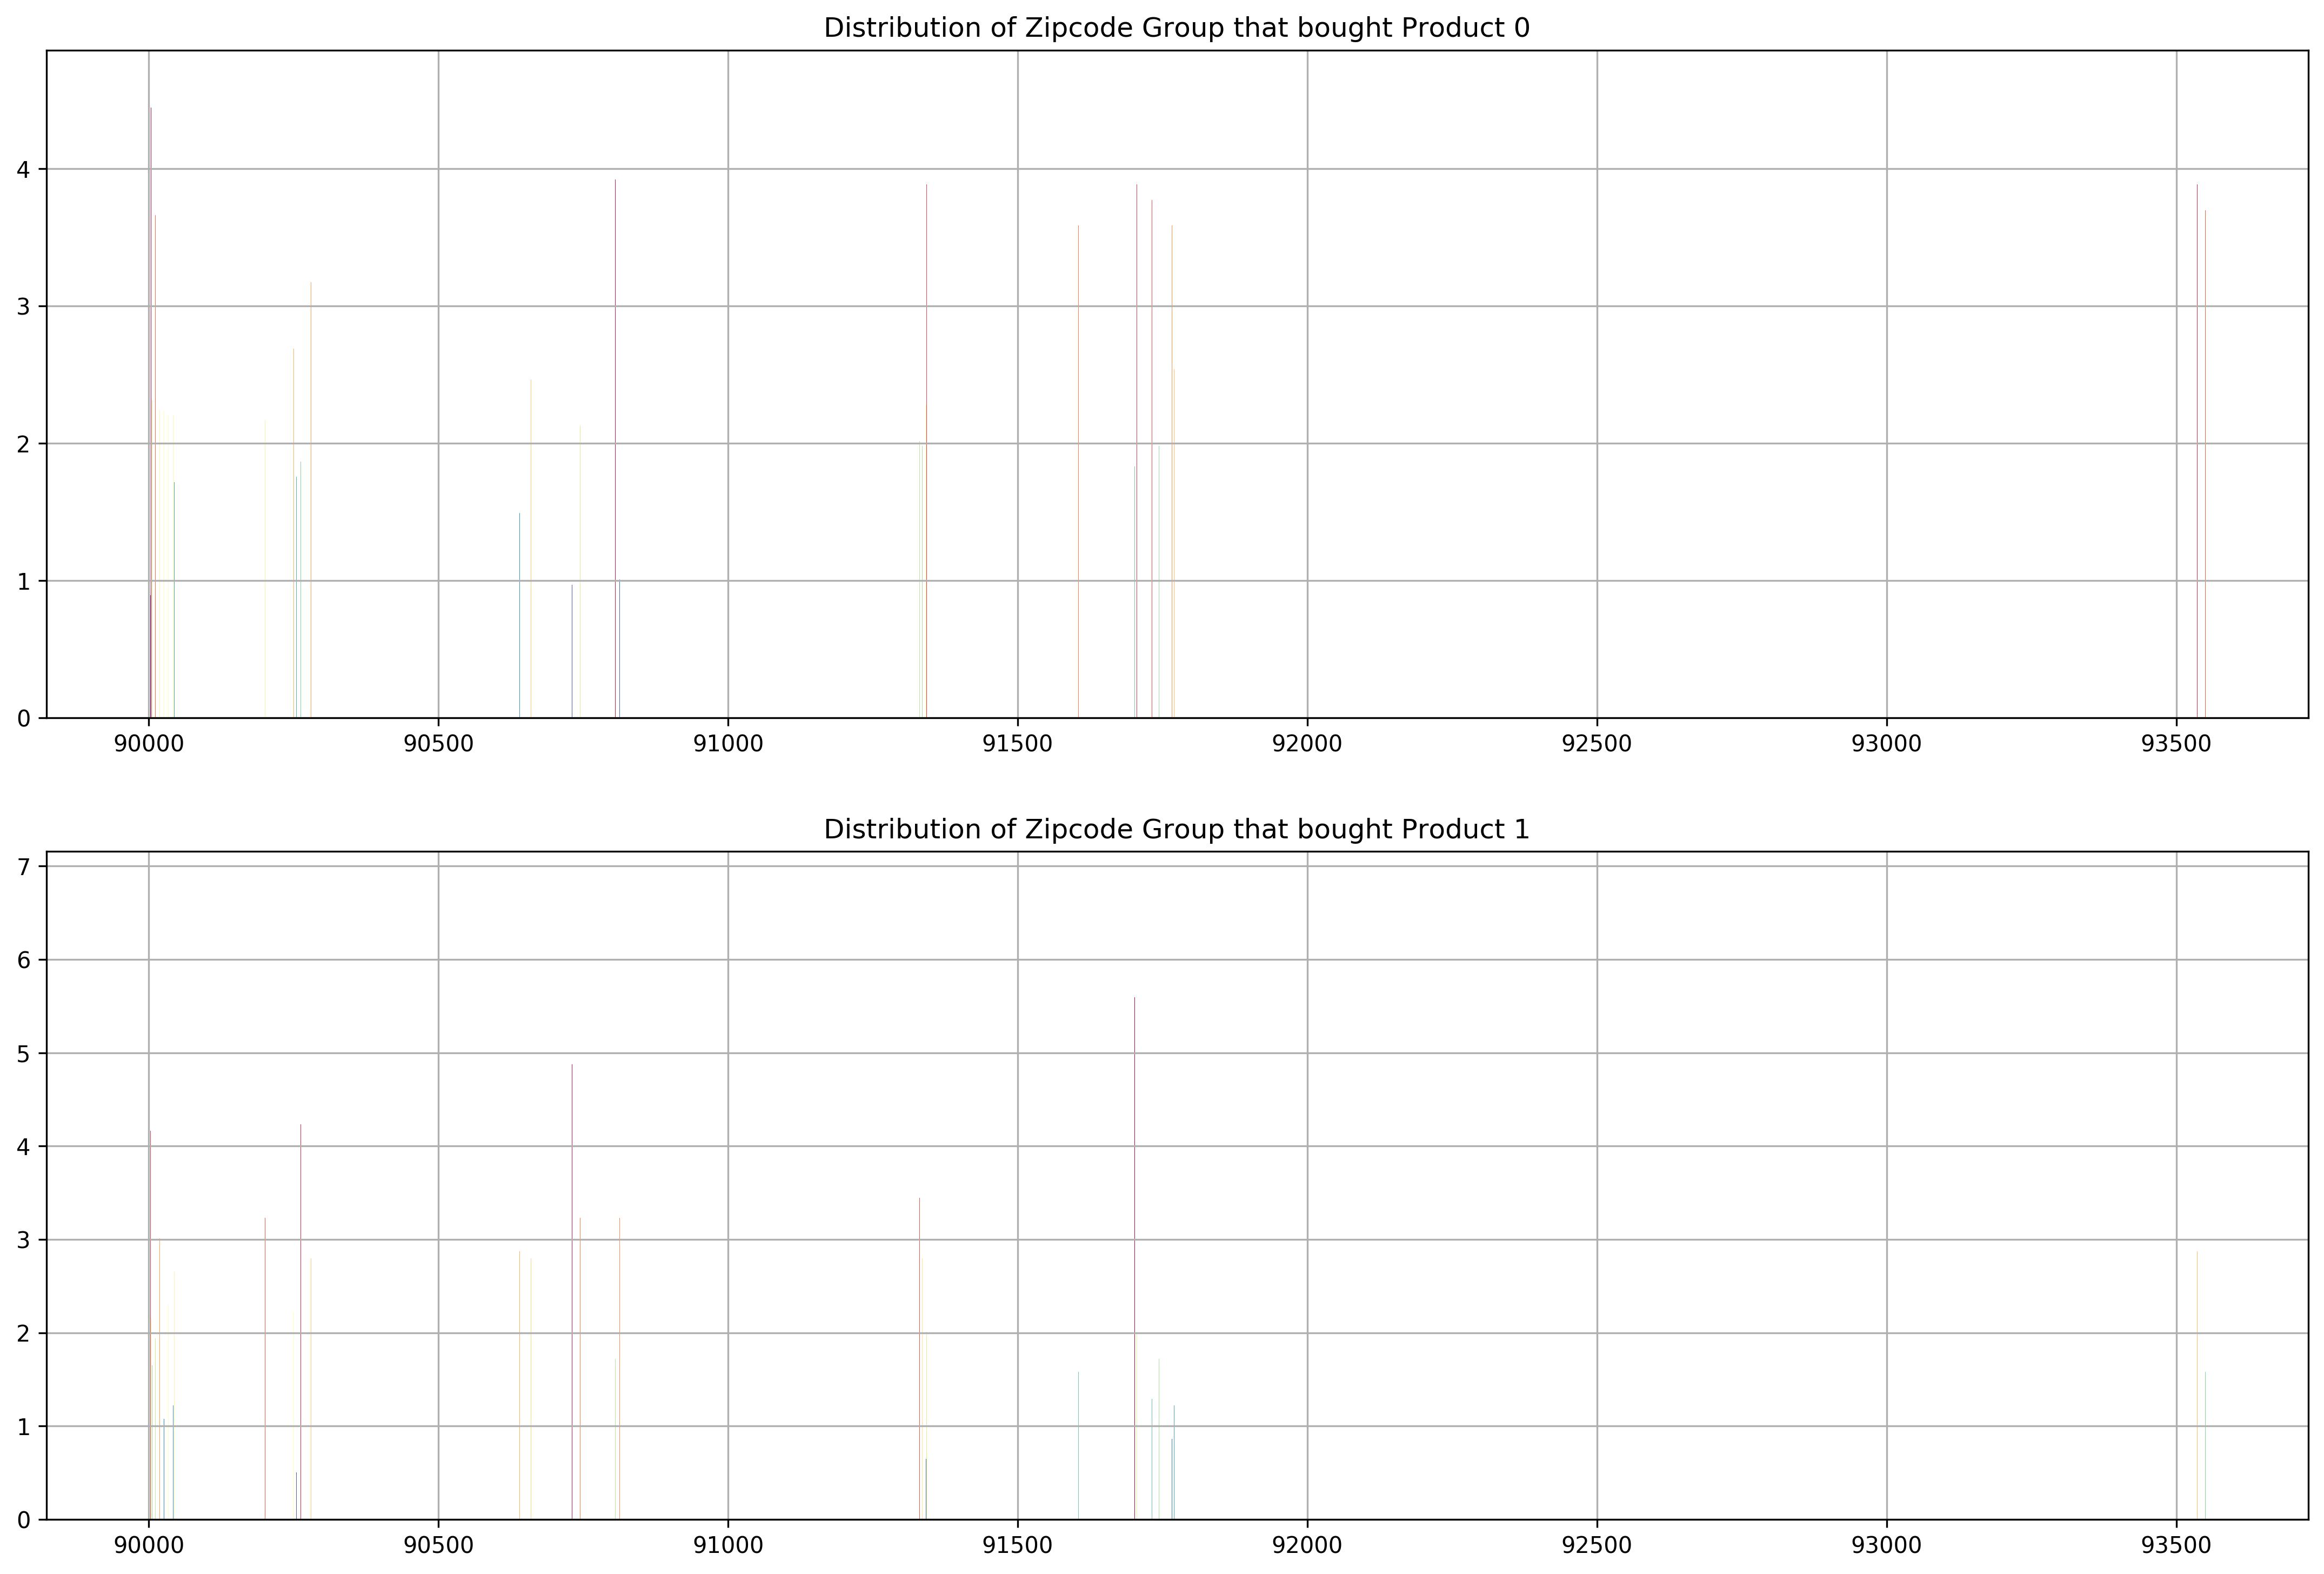

In [82]:
fig, ax = plt.subplots(2, 1)

ax[0].bar(zipcode_pdt_0, np.multiply(count_pdt_0, 100) / np.sum(count_pdt_0), color=get_colors(len(count_pdt_0)))
ax[0].grid()
ax[0].set_title('Distribution of Zipcode Group that bought Product 0');

ax[1].bar(zipcode_pdt_1, np.multiply(count_pdt_1, 100) / np.sum(count_pdt_1), color=get_colors(len(count_pdt_1)))
ax[1].grid()
ax[1].set_title('Distribution of Zipcode Group that bought Product 1');

plt.show();

---
## Modelling

1. Find the historical data with exact same $\mathbf{x}$ and average the choices.
2. Create a weighted average between the number of matches and the overall average rating (If you have alot of matches, you should be more confident in your data - Precision)
    - Number of Matches will help predict with high accuracy, but low precision if very little data points
    - Average overall rating will help  predict with high precision, but low accuracy when we have little data points

$$
y = \frac{5\times\text{Overall Average} + N_{matched} \times \text{Average Matched}}{5 + N_{matched}}
$$

In [56]:
# Find average of choices that
# match individual's age and zipcode exactly
predictions = pd.DataFrame(
    {
        'pred_1': [np.mean(train['choice'][(train['age'] == age) & (train['zipcode'] == zipcode)]) \
                   if np.sum([(train['age'] == age) & (train['zipcode'] == zipcode)]) > 0\
                   else np.mean(train['choice']) \
                   for idx, (age, zipcode) in test[['age', 'zipcode']].iterrows()\
                  ],
        'pred_2': [(\
                    (5 * np.mean(train['choice'])) \
                    + (np.sum([(train['age'] == age) & (train['zipcode'] == zipcode)]) * np.mean(train['choice'][(train['age'] == age) & (train['zipcode'] == zipcode)])) \
                   ) / (5 + np.sum([(train['age'] == age) & (train['zipcode'] == zipcode)])) \
                   for idx, (age, zipcode) in test[['age', 'zipcode']].iterrows()\
                  ]
    },
    index=test['customer_id']
)
predictions.head()

,pred_1,pred_2
customer_id,,
98348,0.000000,0.285352
84860,1.000000,0.530301
89003,0.365854,0.363307
58852,1.000000,0.589014
78007,0.282609,0.288473


In [57]:
test_truth = pd.read_excel('./data/consumer_data_truth.xls', index_col=[0])
test_truth.head()

,age,zipcode,choice
customer_id,,,
98348,40,90706,False
84860,15,90660,False
89003,30,93536,False
58852,40,90044,True
78007,30,90037,False


In [58]:
predictions.join(test_truth['choice'].astype(float)).isna().sum()

pred_1    0
pred_2    2
choice    0
dtype: int64

In [59]:
se_pred_1, se_pred_2 = list(zip(*[((pred_1-choice)**2, (pred_2-choice)**2) for customer_id, (pred_1, pred_2, choice) in predictions.join(test_truth['choice'].astype(float)).iterrows()]))

In [60]:
np.mean(se_pred_1)

0.22863606419273758

In [61]:
np.mean(se_pred_2)

nan

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [25]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train['age'].values.reshape(-1, 1), train['choice'])

/anaconda3/envs/geopandas/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
rf_clf.predict(test['age'].values.reshape(-1, 1))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [35]:
lr_clf = LogisticRegression()
lr_clf.fit(train['age'].values.reshape(-1, 1), train['choice'])

/anaconda3/envs/geopandas/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred = lr_clf.predict(test['age'].values.reshape(-1, 1))

In [45]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
Counter(y_pred)

Counter({0.0: 50})